In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from PIL import ImageFile
from imageio import imread
import sys

In [2]:
ttfiles = os.listdir("/Users/Maggie/Downloads/aerialphotos")

In [3]:
ttfiles.remove('.DS_Store')

In [4]:
#len(ttfiles)

In [5]:
import image_slicer

#for i in ttfiles:
    tiles = image_slicer.slice("/Users/Maggie/Downloads/aerialphotos/"+str(i), 32)

IndentationError: unexpected indent (<ipython-input-5-0b9f880f93a0>, line 4)

In [6]:
files="/Users/Maggie/Downloads/aerialphotos/photo_slices/photos/"
cnt_files = len(os.listdir("/Users/Maggie/Downloads/aerialphotos/photo_slices/photos/half"))

In [7]:
cnt_files

1728

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_240 (Conv2D)          (None, 32, 32, 16)        160       
_________________________________________________________________
leaky_re_lu_133 (LeakyReLU)  (None, 32, 32, 16)        0         
_________________________________________________________________
dropout_133 (Dropout)        (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_241 (Conv2D)          (None, 16, 16, 32)        4640      
_________________________________________________________________
zero_padding2d_34 (ZeroPaddi (None, 17, 17, 32)        0         
_________________________________________________________________
batch_normalization_136 (Bat (None, 17, 17, 32)        128       
_________________________________________________________________
leaky_re_lu_134 (LeakyReLU)  (None, 17, 17, 32)        0         
__________

/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.155853, acc.: 26.85%] [G loss: 0.727644]
1 [D loss: 0.892844, acc.: 48.38%] [G loss: 0.859019]
2 [D loss: 0.762441, acc.: 56.48%] [G loss: 0.891085]
3 [D loss: 0.747475, acc.: 58.33%] [G loss: 0.865630]
4 [D loss: 0.747737, acc.: 55.56%] [G loss: 0.960852]
5 [D loss: 0.611193, acc.: 66.44%] [G loss: 0.951230]


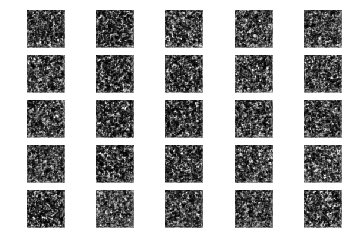

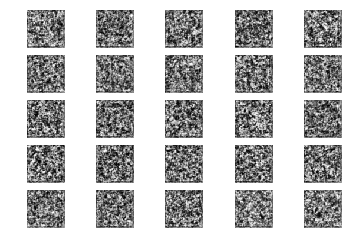

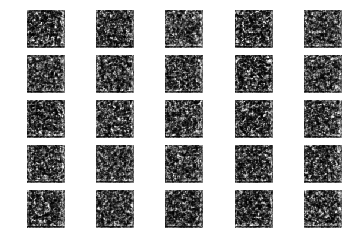

In [55]:
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

def the_gan(epochs, batch_size, sample_epoch):
    
    photo_rows = 64
    photo_cols = 64
    channels = 1
    photo_shape = (photo_rows, photo_cols, channels)
    latent_dim = 100

    optimizer = Adam(0.0002, 0.5)
    

    def the_generator():

        model = Sequential()

        model.add(Dense(128 * 16 * 16, activation="relu", input_dim=latent_dim))
        model.add(Reshape((16, 16, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(Activation("relu"))
        model.add(Conv2D(channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(latent_dim,))
        pic = model(noise)

        return Model(noise, pic)

    def the_discriminator():

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=photo_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        
        model.summary()

        pic = Input(shape=photo_shape)
        validity = model(pic)

        return Model(pic, validity)

    def train_gan(epochs, batch_size=128, sample_epoch=50):
           
        def save_pics(epoch):
            h, w = 5, 5
            noise = np.random.normal(0, 1, (h * w, latent_dim))
            gen_pics = generator.predict(noise)

            # Rescale images 0 - 1
            gen_pics = 0.5 * gen_pics + 0.5

            fig,ax = plt.subplots(h, w)
            cnt = 0
            for i in range(h):
                for j in range(w):
                    ax[i,j].imshow(gen_pics[cnt, :,:,0], cmap='gray')
                    ax[i,j].axis('off')
                    cnt += 1
            fig.savefig("epoch_%d.png" % epoch)


     # Build and compile the discriminator
        discriminator = the_discriminator()
        discriminator.compile(loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

        # Build the generator
        generator = the_generator()

        # The generator takes noise as input and generates images
        z = Input(shape=(latent_dim,))
        pic = generator(z)

        # For the combined model we will only train the generator
        discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = discriminator(pic)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        combined = Model(z, validity)
        combined.compile(loss='binary_crossentropy', optimizer=optimizer)

        # Load the dataset
        files="/Users/Maggie/Downloads/aerialphotos/photo_slices/"
        cnt_files = len(os.listdir("/Users/Maggie/Downloads/aerialphotos/photo_slices/photos"))
        # preprocessing for Keras 
        real_datagen = ImageDataGenerator(#the pixels are rgb so values between 0 and 255 must be normalized
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)
        real_generator = real_datagen.flow_from_directory(
                files,  # this is the target directory
                target_size=(photo_rows, photo_cols),  # all images will be resized to 350x350
                batch_size=cnt_files,
                color_mode = "grayscale",
                class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels

        real_batch = next(real_generator)

        # keras generators may generate an incomplete batch for the last batch in an epoch of data
        if len(real_batch) != batch_size:
                real_batch = next(real_generator)

        assert real_batch[0].shape == (cnt_files, photo_rows, photo_cols, 1), real_batch[0].shape

        photos = real_batch[0]
        # Rescale -1 to 1
        photostd = (photos.astype(np.float32) - 127.5) / 127.5

        X_train = photostd
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        


        for epoch in range(epochs):

                # ---------------------
                #  Train Discriminator
                # ---------------------

            # Select a random batch of images
            index = np.random.randint(0, X_train.shape[0], batch_size)
            pics = X_train[index]

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_pics = generator.predict(noise)

            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(pics, valid)
            d_loss_fake = discriminator.train_on_batch(gen_pics, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

                # ---------------------
                #  Train Generator
                # ---------------------

            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            if epoch % sample_epoch == 0:
                save_pics(epoch)
            
    train_gan(epochs, batch_size, sample_epoch)
    
the_gan(epochs=6, batch_size=216, sample_epoch=2)